##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# コピュラ入門

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Gaussian_Copula"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Gaussian_Copula.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Gaussian_Copula.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Gaussian_Copula.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

[copula]（https://en.wikipedia.org/wiki/Copula_(probability_theory%29）とは、ランダム変数間の依存関係を捉えるための古典的な手法です。より正式には、コピュラは、マージナリゼーションによって $U_i \sim \text{Uniform}(0, 1)$ が得られる多変量分布 $C(U_1, U_2, ...., U_n)$ です。

コピュラを使用すると任意の周辺分布を持つ多変量分布を作成できるため、コピュラは非常に興味深い関数と言えます。以下にそのレシピを示します。

- [確率積分変換](https://en.wikipedia.org/wiki/Probability_integral_transform)を使って、任意の連続分布 R.V. $X$ を一様分布 $F_X(X)$ に変換します。$F_X$ は $X$ の CDF（累積分布関数）です。
- コピュラ（二変量とした場合）$C(U, V)$ がある場合、$U$ と $V$ には一様周辺分布があります。
- ここで、関心のある R.V が $X, Y$ である場合に、$C'(X, Y) = C(F_X(X), F_Y(Y))$ という新しい分布を作成します。$X$ と $Y$ の周辺分布は目的どおりの分布です。

周辺分布は単変量であるため、測定やモデル化が行いやすい場合があります。コピュラは周辺分布から開始することを可能にしますが、次元間の任意の相関関係を得ることも可能です。


# ガウスコピュラ

コピュラがどのように成立しているかを説明するために、多変量のガウス相関関係に従って依存関係を捉えるケースを考察しましょう。ガウスコピュラは $C(u_1, u_2, ...u_n) = \Phi_\Sigma(\Phi^{-1}(u_1), \Phi^{-1}(u_2), ... \Phi^{-1}(u_n))$ によって得られるもので、$\Phi_\Sigma$ は多変量正規分布の CFD を表し、共分散 $\Sigma$ と平均値 0 を持ち、$\Phi^{-1}$ は標準正規分布の逆 CDF です。

正規の逆 CFD を適用すると、一様次元をラップして正規に分布されるようになります。多変量正規分布の CDF を適用すると、分布が押しつぶされてわずかに均一になり、ガウス相関が得られます。

したがって、ガウスコピュラは、一様な周辺分布を持つ単位超立方体 $[0, 1]^n$ にわたる分布であることがわかります。

このように定義されると、ガウスコピュラは `tfd.TransformedDistribution` と適切な `Bijector` で実装することができます。つまり、[`tfb.NormalCDF`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/NormalCDF) バイジェクターによって実装された正規分布の逆 CDF を使用して、多変量正規分布を変換しているということです。

以下では、共分散がコレスキー因子によってパラメータ化される（したがって、`MultivariateNormalTriL` の共分散）という 1 つの単純化した仮定で、ガウスコピュラを実装します。（ほかの `tf.linalg.LinearOperators` を使用して、行列のないさまざまな仮定をエンコードすることができます。）

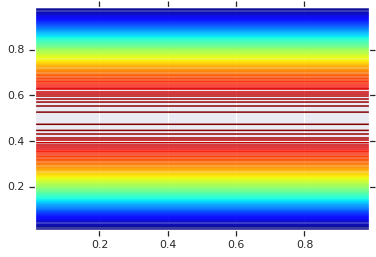

In [ ]:
class GaussianCopulaTriL(tfd.TransformedDistribution):
  """Takes a location, and lower triangular matrix for the Cholesky factor."""
  def __init__(self, loc, scale_tril):
    super(GaussianCopulaTriL, self).__init__(
        distribution=tfd.MultivariateNormalTriL(
            loc=loc,
            scale_tril=scale_tril),
        bijector=tfb.NormalCDF(),
        validate_args=False,
        name="GaussianCopulaTriLUniform")


# Plot an example of this.
unit_interval = np.linspace(0.01, 0.99, num=200, dtype=np.float32)
x_grid, y_grid = np.meshgrid(unit_interval, unit_interval)
coordinates = np.concatenate(
    [x_grid[..., np.newaxis],
     y_grid[..., np.newaxis]], axis=-1)

pdf = GaussianCopulaTriL(
    loc=[0., 0.],
    scale_tril=[[1., 0.8], [0., 0.6]],
).prob(coordinates)

# Plot its density.

plt.contour(x_grid, y_grid, pdf, 100, cmap=plt.cm.jet);

しかし、このようなモデルの力は、確率積分変換を使用して任意の R.V. にコピュラを使用するところにあります。こうすることで、任意の周辺分布を指定し、コピュラを使って接合することができます。

次のモデルから開始します。

$$\begin{align*} X &amp;\sim \text{Kumaraswamy}(a, b) \ Y &amp;\sim \text{Gumbel}(\mu, \beta) \end{align*}$$

そして、コピュラを使って、二変量 R.V. $Z$ を取得します。これには、周辺分布の [Kumaraswamy](https://en.wikipedia.org/wiki/Kumaraswamy_distribution) と [Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution) があります。

まず、これらの 2 つの R.V. で生成された分布をプロットしましょう。これは、コピュラを適用したときの比較の基準としてのみ使用します。

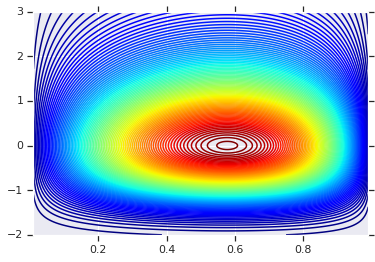

In [ ]:
a = 2.0
b = 2.0
gloc = 0.
gscale = 1.

x = tfd.Kumaraswamy(a, b)
y = tfd.Gumbel(loc=gloc, scale=gscale)

# Plot the distributions, assuming independence
x_axis_interval = np.linspace(0.01, 0.99, num=200, dtype=np.float32)
y_axis_interval = np.linspace(-2., 3., num=200, dtype=np.float32)
x_grid, y_grid = np.meshgrid(x_axis_interval, y_axis_interval)

pdf = x.prob(x_grid) * y.prob(y_grid)

# Plot its density

plt.contour(x_grid, y_grid, pdf, 100, cmap=plt.cm.jet);

# 異なる周辺分布を使用した同時分布

次に、ガウスコピュラを使用して分布を接合し、それをプロットします。ここでも、`TransformedDistribution` を適切な `Bijector` に適用して、目的の周辺分布を取得します。

具体的には、さまざまなベクトルで異なるバイジェクターを適用（全単射変換のままです）する [`Blockwise`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Blockwise) バイジェクターを使用します。

これで、必要としているコピュラを定義できるようになりました。ターゲットとなる周辺分布のリスト（バイジェクターとしてエンコード）があれば、コピュラを使用し、指定された周辺分布を持つ新しい分布を簡単に構築できます。


In [ ]:
class WarpedGaussianCopula(tfd.TransformedDistribution):
  """Application of a Gaussian Copula on a list of target marginals.

  This implements an application of a Gaussian Copula. Given [x_0, ... x_n]
  which are distributed marginally (with CDF) [F_0, ... F_n],
  `GaussianCopula` represents an application of the Copula, such that the
  resulting multivariate distribution has the above specified marginals.

  The marginals are specified by `marginal_bijectors`: These are
  bijectors whose `inverse` encodes the CDF and `forward` the inverse CDF.

  block_sizes is a 1-D Tensor to determine splits for `marginal_bijectors`
  length should be same as length of `marginal_bijectors`.
  See tfb.Blockwise for details
  """
  def __init__(self, loc, scale_tril, marginal_bijectors, block_sizes=None):
    super(WarpedGaussianCopula, self).__init__(
        distribution=GaussianCopulaTriL(loc=loc, scale_tril=scale_tril),
        bijector=tfb.Blockwise(bijectors=marginal_bijectors,
                               block_sizes=block_sizes),
        validate_args=False,
        name="GaussianCopula")

最後に、このガウスコピュラを実際に使用してみましょう。バリアンス 1 に対応する $\begin{bmatrix}1 &amp; 0\\rho &amp; \sqrt{(1-\rho^2)}\end{bmatrix}$ のコレスキー、そして多変量正規分布の相関 $\rho$ を使用します。

いくつかのケースを見てみましょう。 

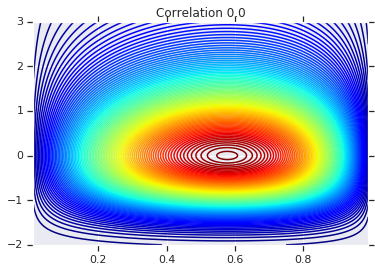

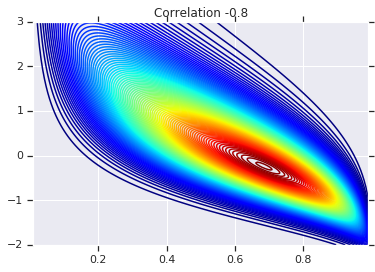

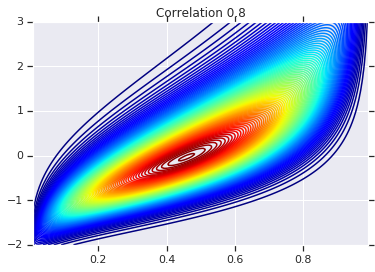

In [ ]:
# Create our coordinates:
coordinates = np.concatenate(
    [x_grid[..., np.newaxis], y_grid[..., np.newaxis]], -1)


def create_gaussian_copula(correlation):
  # Use Gaussian Copula to add dependence.
  return WarpedGaussianCopula(
      loc=[0.,  0.],
      scale_tril=[[1., 0.], [correlation, tf.sqrt(1. - correlation ** 2)]],
      # These encode the marginals we want. In this case we want X_0 has
      # Kumaraswamy marginal, and X_1 has Gumbel marginal.

      marginal_bijectors=[
          tfb.Invert(tfb.KumaraswamyCDF(a, b)),
          tfb.Invert(tfb.GumbelCDF(loc=0., scale=1.))])


# Note that the zero case will correspond to independent marginals!
correlations = [0., -0.8, 0.8]
copulas = []
probs = []
for correlation in correlations:
  copula = create_gaussian_copula(correlation)
  copulas.append(copula)
  probs.append(copula.prob(coordinates))


# Plot it's density

for correlation, copula_prob in zip(correlations, probs):
  plt.figure()
  plt.contour(x_grid, y_grid, copula_prob, 100, cmap=plt.cm.jet)
  plt.title('Correlation {}'.format(correlation))

最後に、実際に求めていた周辺分布を実際に取得することを確認しましょう。

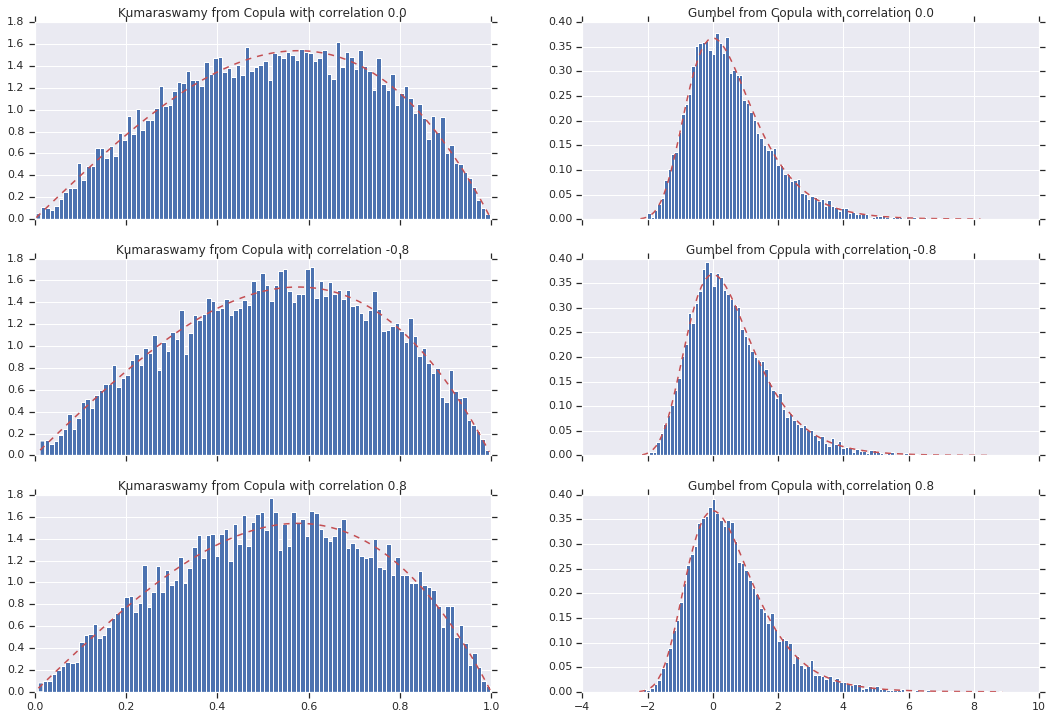

In [ ]:
def kumaraswamy_pdf(x):
    return tfd.Kumaraswamy(a, b).prob(np.float32(x))

def gumbel_pdf(x):
    return tfd.Gumbel(gloc, gscale).prob(np.float32(x))


copula_samples = []
for copula in copulas:
  copula_samples.append(copula.sample(10000))

plot_rows = len(correlations)
plot_cols = 2  # for 2  densities [kumarswamy, gumbel]
fig, axes = plt.subplots(plot_rows, plot_cols, sharex='col', figsize=(18,12))

# Let's marginalize out on each, and plot the samples.

for i, (correlation, copula_sample) in enumerate(zip(correlations, copula_samples)):
  k = copula_sample[..., 0].numpy()
  g = copula_sample[..., 1].numpy()


  _, bins, _ = axes[i, 0].hist(k, bins=100, density=True)
  axes[i, 0].plot(bins, kumaraswamy_pdf(bins), 'r--')
  axes[i, 0].set_title('Kumaraswamy from Copula with correlation {}'.format(correlation))

  _, bins, _ = axes[i, 1].hist(g, bins=100, density=True)
  axes[i, 1].plot(bins, gumbel_pdf(bins), 'r--')
  axes[i, 1].set_title('Gumbel from Copula with correlation {}'.format(correlation))
  

# 結論

以上です！`Bijector` API を使用してガウスコピュラを構築できることをお見せしました。

一般的には、`Bijector` API を使用してバイジェクターを記述し、分布でこれらを作成すると、柔軟にモデル化できる豊富な分布族を作成できます。